<a href="https://colab.research.google.com/github/yunariver/newproject/blob/main/11_20_%EC%A0%9C%EC%B6%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD


## 함수 정의
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    self.fc1 = nn.Linear(in_features=2, out_features=16)
    self.fc1_act = nn.ReLU()

    self.fc2 = nn.Linear(in_features=16, out_features=32)
    self.fc2_act = nn.ReLU()

    self.fc3 = nn.Linear(in_features=32, out_features=10)
  def forward(self, x):
    x = self.fc1(x)
    x = self.fc1_act(x)

    x = self.fc2(x)
    x = self.fc2_act(x)

    x = self.fc3(x)

    return x
def get_device():
  if torch.cuda.is_available(): DEVICE='cuda'
  elif torch.backends.mps.is_available(): DEVICE='mps'
  else: DEVICE='cpu'





def vis_losses_accs(losses, accs):
    fig, axes = plt.subplots(2, 1, figsize=(10, 7))

    axes[0].plot(losses)
    axes[1].plot(accs)

    axes[0].set_ylabel("Loss", fontsize=12)
    axes[1].set_ylabel("Accuracy", fontsize=12)
    axes[1].set_xlabel("EPOCH", fontsize=12)

    fig.tight_layout()



Epoch 10:   0%|          | 0/13 [00:00<?, ?batch/s, accuracy=100, loss=0.0526]


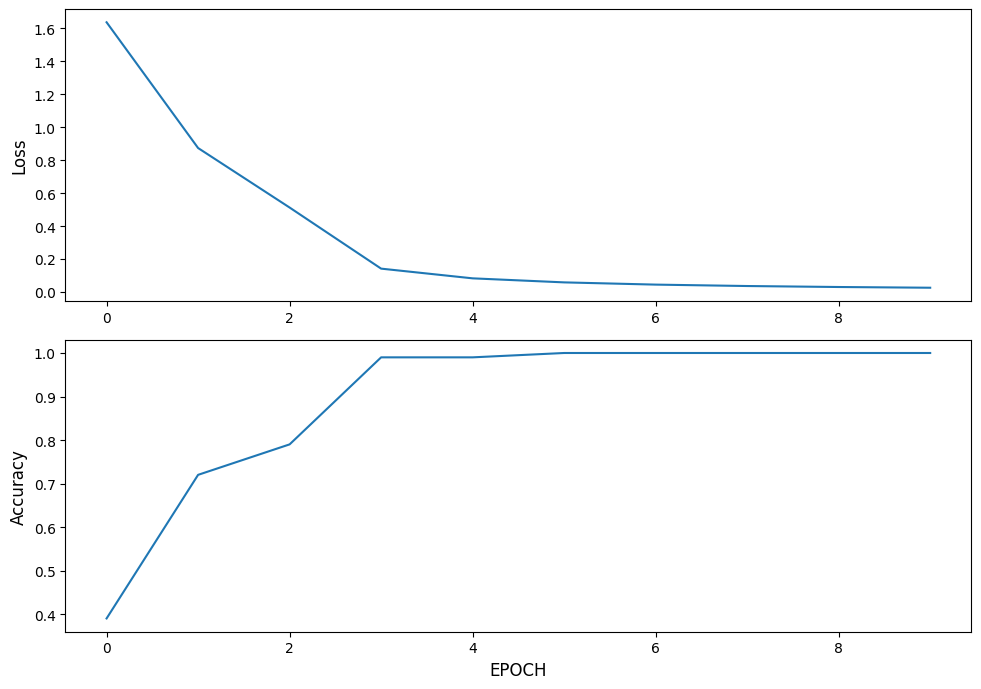

In [ ]:
##main
from tqdm import tqdm


N_SAMPLES = 100
BATCH_SIZE = 8
EPOCHS = 10
LR = 0.1

X, y = make_blobs(n_samples=100, centers=4, cluster_std=0.3, random_state=0)
dataset = TensorDataset(torch.FloatTensor(X), torch.IntTensor(y))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

DEVICE = get_device()
model = Classifier()
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)

#training
losses, accs = [], []
for epoch in range(EPOCHS):
  epoch_loss, n_corrects = 0., 0
  with tqdm(dataloader, unit="batch") as tepoch:
    for X, y in dataloader:
      X, y = X.to(DEVICE), y.to(DEVICE)
      tepoch.set_description(f"Epoch {epoch+1}")

      pred = model(X)
      loss = loss_function(pred, y.long())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item() * len(X)
      _, pred_class = torch.max(pred.data, dim=1) # 각 열(1)마다 최댓값의 위치 = class 결정
      #  .data는  역전파 계산이 필요없어서 data만 사용
      n_corrects += (pred_class == y).sum().item()

      tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy)

    epoch_loss /= N_SAMPLES
    epoch_acc = n_corrects / N_SAMPLES

  losses.append(epoch_loss)
  accs.append(epoch_acc)



vis_losses_accs(losses, accs)




<ipython-input-14-160bccd0af0f>:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds = np.array(preds)
<ipython-input-14-160bccd0af0f>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(preds)


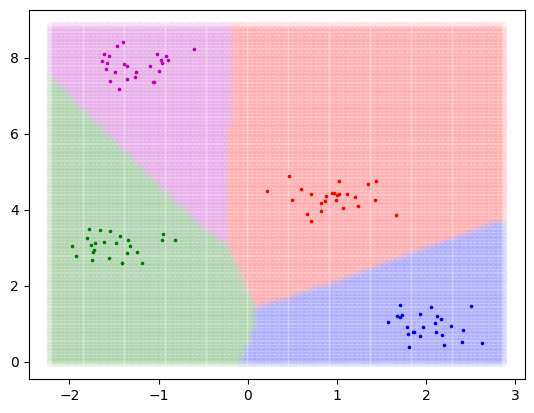

In [ ]:
#Decision Boundary

import matplotlib.pyplot as plt
import numpy as np
colors = ["r", "b", "g", "m"]

fig, ax = plt.subplots()
for k, col in enumerate(colors):
    cluster_data = (y == k)
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

x_lim, y_lim = ax.get_xlim(), ax.get_ylim()
x1 = np.linspace(x_lim[0], x_lim[1], 100)
x2 = np.linspace(y_lim[0], y_lim[1], 100)
X1, X2 = np.meshgrid(x1, x2)

X_db = np.hstack([X1.reshape(-1, 1), X2.reshape(-1, 1)])
X_db = torch.tensor(X_db, dtype=torch.float32)
preds = []
for x_db in X_db:
  x_db = x_db.view(1, -1)
  pred = model(x_db)
  _, pred_class = torch.max(pred.data, dim=1)
  preds.append(pred_class)
preds = np.array(preds)

for k, col in enumerate(colors):
  X_ = X_db[preds == k]
  ax.scatter(X_[:,0], X_[:,1], c=col, alpha=0.05)
